In [51]:
import wfdb
import numpy as np
import padasip as pa
#wfdb.io.dl_database('mitdb', './mitdb', records='all', annotators='all', keep_subdirs=True, overwrite=False)

#Implementación de los filtros sugeridos en el paper (implementación I)

In [180]:
def filter_with_NSSLMS(in_sig, desired_sig, n = 1, m = 0.01):
    # creation of data
    N = len(in_sig)
    filt_size =  n
    x = pa.input_from_history(in_sig,filt_size)
    d = desired_sig.reshape(len(desired_sig), 1)
    d = d[:N-filt_size+1, 0]

    f = pa.filters.FilterNSSLMS(n=filt_size, mu=m, w="zeros")
    y, e, w = f.run(d, x)
    
    return y, e , w   

def filter_with_SSLMS(in_sig, desired_sig, n = 1, m = 0.01):
    # creation of data
    N = len(in_sig)
    filt_size =  n
    x = pa.input_from_history(in_sig,filt_size)
    d = desired_sig.reshape(len(desired_sig), 1)
    d = d[:N-filt_size+1, 0]

    f = pa.filters.FilterSSLMS(n=filt_size, mu=m, w="zeros")
    y, e, w = f.run(d, x)
    
    return y, e , w   

def filter_with_LMS(in_sig, desired_sig, n = 1, m = 0.01):
    # creation of data
    N = len(in_sig)
    filt_size =  n
    x = pa.input_from_history(in_sig,filt_size)
    d = desired_sig.reshape(len(desired_sig), 1)
    d = d[:N-filt_size+1, 0]

    f = pa.filters.FilterLMS(n=filt_size, mu=m, w="zeros")
    y, e, w = f.run(d, x)
    
    return y, e , w   

def filter_with_NLMS(in_sig, desired_sig, n = 1, m = 0.01):
    # creation of data
    N = len(in_sig)
    filt_size =  n
    x = pa.input_from_history(in_sig,filt_size)
    d = desired_sig.reshape(len(desired_sig), 1)
    d = d[:N-filt_size+1, 0]

    f = pa.filters.FilterNLMS(n=filt_size, mu=m, w="zeros")
    y, e, w = f.run(d, x)
    
    return y, e , w   


In [214]:
#Filtramos el wandering noise
def filter_wandering_noise(sig):
    d = np.ones(len(sig))
    filt_size = 1
    y, e, _= filter_with_LMS(d, sig, n = filt_size, m = 0.01)
    return e

def create_xhz_ref(length, freq, sr):

    N = 2*np.cos(2*np.pi*freq/sr)
    e = np.ones(length)
    e[0]=0.5
    for n in range(2, e.size):
        e[n] = N*e[n-1]-e[n-2]

    return e

def filter_60hz(signal, fs=360):
    ref = create_xhz_ref(len(signal), 60, 360) 
    y, e, w = filter_with_LMS(ref, signal, n = 2, m = 0.01)
    ref = create_xhz_ref(len(e), 120, 360) 
    y, e, w = filter_with_LMS(ref, e, n = 2, m = 0.01)
    return e

from ecgdetectors import Detectors

def detect_r_peak(sig):
    detectors = Detectors(360)
    r_peaks = np.array(detectors.engzee_detector(sig))
    deltas = np.zeros(len(sig))
    deltas[r_peaks] = 1

    return deltas

def arf_filter(signal, filt_size, mu = 1, offset = 150):
    desired3 = signal
    deltas_og = detect_r_peak(desired3)
    deltas = np.concatenate((np.zeros(offset),deltas_og))[:-offset]

    y, e, w = filter_with_NLMS(deltas, desired3, n = filt_size, m=mu)

    return e, y

# Filtro Baseline Wander

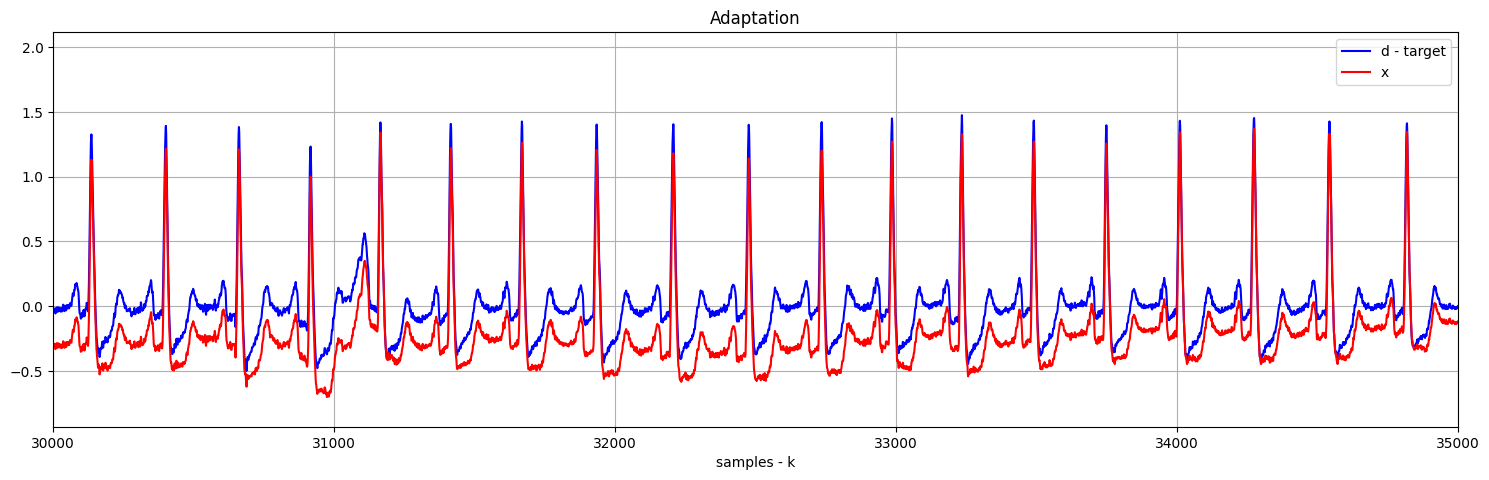

In [55]:
# Extract ECG data from two leads as numpy arrays
lead1_data = record.p_signal[:, 0]  # First lead
lead2_data = record.p_signal[:, 1]  # Second lead

N = len(lead1_data)//10
x = lead1_data[:N]

filtered_sig = filter_wandering_noise(x)

# show results
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(filtered_sig,"b", label="d - target");plt.legend()
plt.plot(x,"r", label="x");plt.legend()
plt.xlim(30e3, 35e3)
plt.tight_layout()
plt.grid()
plt.show()

# Filtro 60hz

In [56]:
import wfdb
import matplotlib.pyplot as plt

# Load the ECG record from the MIT-BIH Arrhythmia Database
record_name = '100'  # Change this to the desired record name
record = wfdb.rdrecord(record_name, pn_dir='mitdb')

# Print additional information about the ECG record
record_info = wfdb.rdheader(record_name, pn_dir='mitdb')

# Extract ECG data from two leads as numpy arrays
lead1_data = record.p_signal[:, 0]  # First lead
lead2_data = record.p_signal[:, 1]  # Second lead


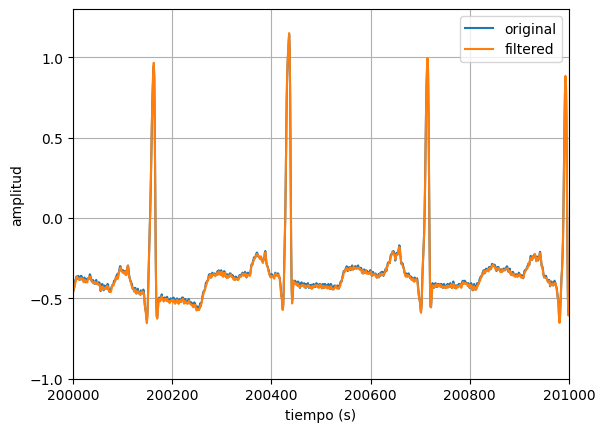

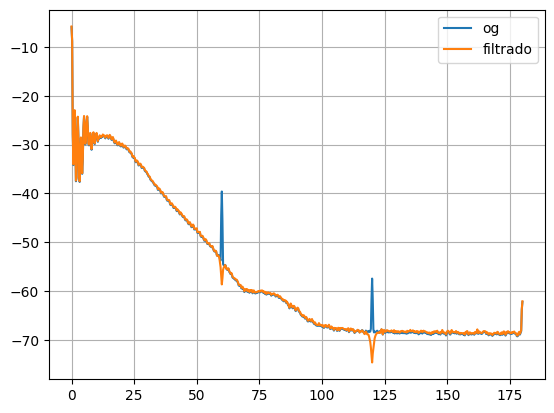

In [57]:
filtered = filter_60hz(lead1_data, 360)
plt.plot(lead1_data, label='original')
plt.plot(filtered, label='filtered')
plt.xlim(200000, 201000)
plt.legend()
plt.grid()
plt.ylim(-1,1.3)
plt.xlabel('tiempo (s)')
plt.ylabel('amplitud')
plt.show()

a, b = plt.mlab.psd(lead1_data, Fs=360, NFFT=360*4)
plt.plot(b,10*np.log10(a), label='og')
a, b = plt.mlab.psd(filtered, Fs=360, NFFT=360*4)
plt.plot(b,10*np.log10(a), label='filtrado')
plt.legend()
plt.grid()

plt.show()

# Implementación secuencial de los filtros:

# Denoising Completo

In [226]:
record_name = '212'
index = 71342
padding_right = 2000
padding_left = 20000

record2 = wfdb.rdrecord(record_name, pn_dir='mitdb', sampfrom = index-padding_left, sampto= index+padding_right)

# Extract ECG data from two leads as numpy arrays
lead1_data = record2.p_signal[:, 0]  # First lead
lead2_data = record2.p_signal[:, 1]  # Second lead


filtered_sig1 = filter_wandering_noise(lead1_data)

filtered_sig2 = filter_60hz(filtered_sig1, 360)

arf_error, filtered_sig3 = arf_filter(filtered_sig2, 250, mu=0.5)

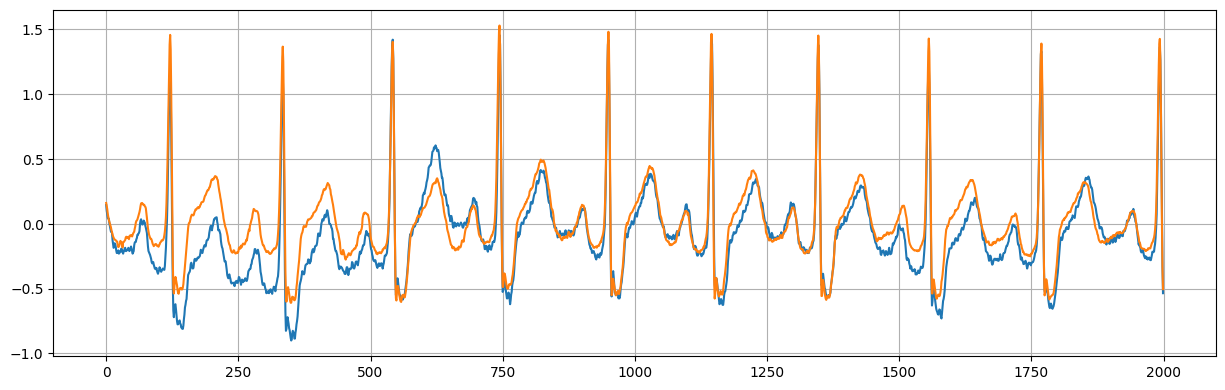

In [229]:
plt.figure(figsize=(15,4.5))
plt.plot(lead1_data[4500:6500], label= 'señal original')
plt.plot(filtered_sig3[4500:6500], label='señal filtrada')
plt.grid()

otro filtrado total, más jodido

In [250]:
data = np.genfromtxt('test_ecg.csv', delimiter=',')
data = data[:10000]

In [251]:
data = np.genfromtxt('test_ecg.csv', delimiter=',')
data = data[:8000]

filtered_sig1 = filter_wandering_noise(data)

filtered_sig2 = filter_60hz(filtered_sig1, 360)

arf_error, filtered_sig3 = arf_filter(filtered_sig2, 250, mu=0.1)

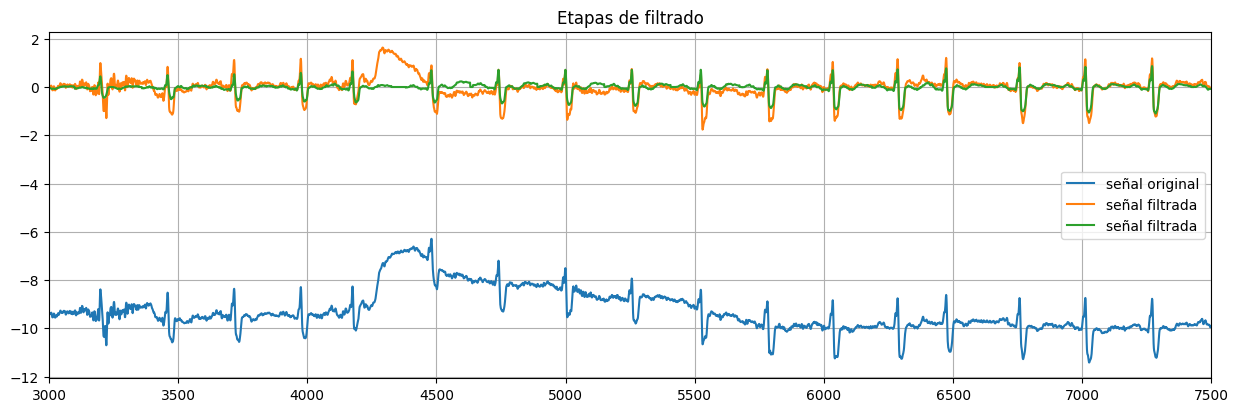

In [259]:
plt.figure(figsize=(15,4.5))
plt.plot(data, label= 'señal original')
plt.plot(filtered_sig2, label='señal filtrada')
plt.plot(filtered_sig3, label='señal filtrada')
plt.xlim(3000,7500)
plt.title('Etapas de filtrado')
plt.legend()
plt.grid()

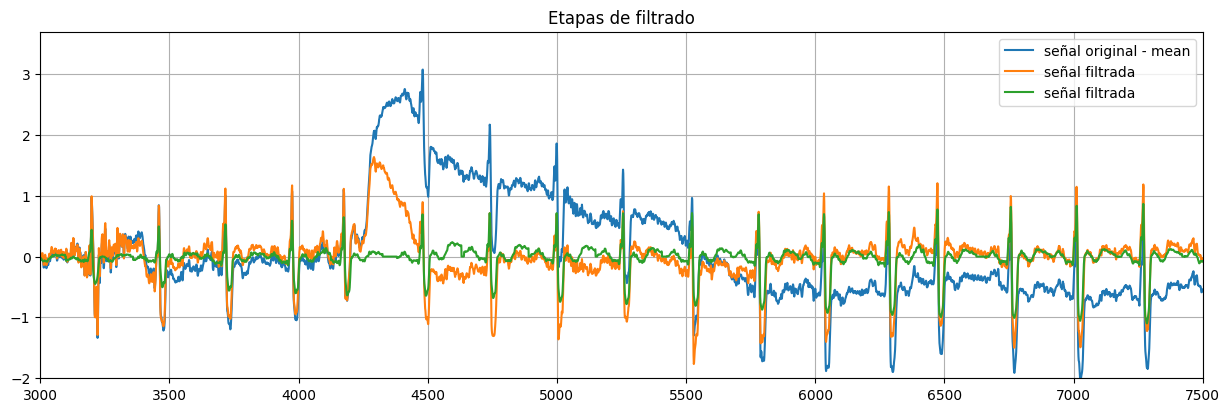

In [261]:
from statistics import mean
plt.figure(figsize=(15,4.5))
plt.plot(data-(mean(data)), label= 'señal original - mean')
plt.plot(filtered_sig2, label='señal filtrada')
plt.plot(filtered_sig3, label='señal filtrada')
plt.xlim(3000,7500)
plt.ylim(-2,)
plt.title('Etapas de filtrado')
plt.legend()
plt.grid()

# Lectura de P-Wave annotations

In [115]:
#trato de identificar ECG con arritmias piolas

list_of_interest = ['R', 'x', 'S', '[', ']', '!']
#list_of_interest = ['S']
list_of_interesting_ecgs = []


for j in range(100,234):
    try:
        annotations = wfdb.rdann('mitdb/'+str(j), extension='atr')
        # Access the annotation samples and symbols
        annotation_samples = annotations.sample
        annotation_symbols = annotations.symbol
        # Print the first 10 annotation samples and symbols
        for i in range(len(annotation_samples)):
            if (annotation_symbols[i])!='N':
                if (annotation_symbols[i]) in list_of_interest:
                    #print(f"Sample: {annotation_samples[i]}, Symbol: {annotation_symbols[i]}")
                    if j not in list_of_interesting_ecgs:
                        list_of_interesting_ecgs.append(j)
    except:
        pass
    
print(list_of_interesting_ecgs)

[108, 118, 124, 201, 207, 208, 212, 219, 231, 232]


In [118]:
annotations = wfdb.rdann('mitdb/'+str(219), extension='atr')
# Access the annotation samples and symbols
annotation_samples = annotations.sample
annotation_symbols = annotations.symbol
# Print the first 10 annotation samples and symbols
for i in range(len(annotation_samples)):
    if (annotation_symbols[i])!='N':
        if (annotation_symbols[i]) in list_of_interest:
            print(f"Sample: {annotation_samples[i]}, Symbol: {annotation_symbols[i]}")


Sample: 302003, Symbol: x
Sample: 303821, Symbol: x
Sample: 305606, Symbol: x
Sample: 322204, Symbol: x
Sample: 323098, Symbol: x
Sample: 323968, Symbol: x
Sample: 324800, Symbol: x
Sample: 325647, Symbol: x
Sample: 331684, Symbol: x
Sample: 332528, Symbol: x
Sample: 333382, Symbol: x
Sample: 334210, Symbol: x
Sample: 335042, Symbol: x
Sample: 335882, Symbol: x
Sample: 336733, Symbol: x
Sample: 337562, Symbol: x
Sample: 338379, Symbol: x
Sample: 340682, Symbol: x
Sample: 341542, Symbol: x
Sample: 342379, Symbol: x
Sample: 343200, Symbol: x
Sample: 344038, Symbol: x
Sample: 344865, Symbol: x
Sample: 346091, Symbol: x
Sample: 346931, Symbol: x
Sample: 347770, Symbol: x
Sample: 348303, Symbol: x
Sample: 349145, Symbol: x
Sample: 349974, Symbol: x
Sample: 350792, Symbol: x
Sample: 351346, Symbol: x
Sample: 352173, Symbol: x
Sample: 352994, Symbol: x
Sample: 353544, Symbol: x
Sample: 354377, Symbol: x
Sample: 355212, Symbol: x
Sample: 356033, Symbol: x
Sample: 356833, Symbol: x
Sample: 3576

# Procesamos una señal con fibrilacion atrial

Record Name: JS00763
Number of Leads: 12
Sampling Frequency: 500 Hz
Record Duration: 10.0 seconds
Lead Names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


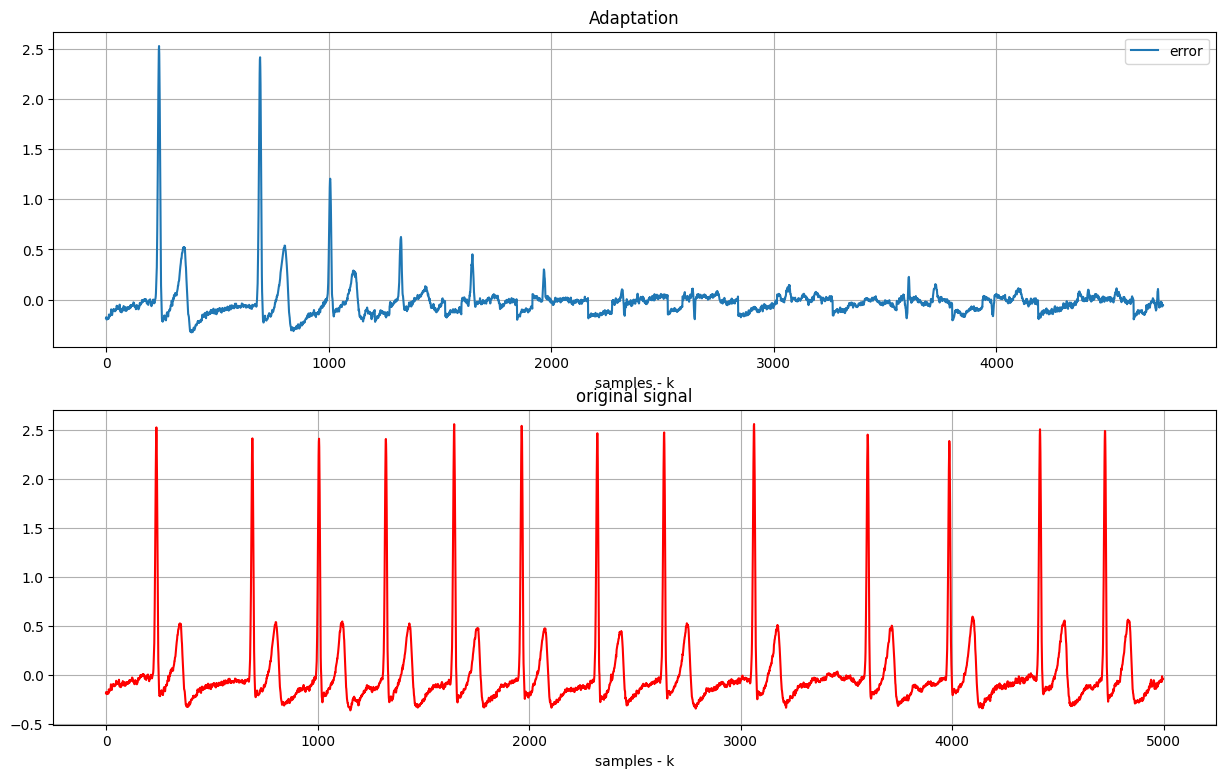

In [231]:
#https://physionet.org/content/ecg-arrhythmia/1.0.0/#files-panel

record_name2 = 'JS00763'  # Change this to the desired record name

dir = 'ecg-arrhythmia/WFDBRecords/01/017'
record2 = wfdb.rdrecord(record_name2, pn_dir=dir)


# Plot the selected leads

record_info2 = wfdb.rdheader(record_name2, pn_dir=dir)

print(f"Record Name: {record_info2.record_name}")
print(f"Number of Leads: {record_info2.n_sig}")
print(f"Sampling Frequency: {record_info2.fs} Hz")
print(f"Record Duration: {record_info2.sig_len / record_info2.fs} seconds")
print(f"Lead Names: {record_info2.sig_name}")

# You can access more information from the record_info object as needed.


data = record2.p_signal[:, 10]


filtered_sig1 = filter_wandering_noise(data)

filtered_sig2 = filter_60hz(filtered_sig1, 500)

arf_error, filtered_sig3 = arf_filter(filtered_sig2, 250, mu=0.5, offset = 200)

loc = 16768
buff = 2000

plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
#plt.plot(filtered_sig3, label='y')
plt.plot((arf_error), label='error')
plt.legend()
plt.grid()
#plt.xlim(loc-buff,loc+buff)
plt.subplot(212);plt.title("original signal");plt.xlabel("samples - k")
plt.plot((filtered_sig2), 'r', label='signal')
#plt.plot((detect_r_peak(filtered_sig2)), label='r spikes')
plt.grid()
#plt.xlim(loc-buff,loc+buff)
plt.show()

Text(0.5, 1.0, 'Autocorrelación del error')

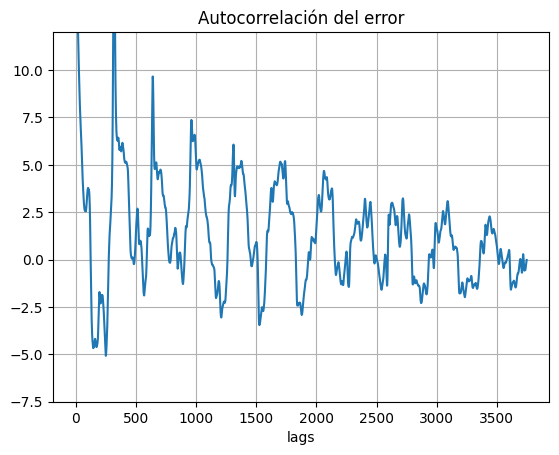

In [234]:
err = arf_error[1000:]
autocorr = np.correlate(err,err, mode='full')
plt.grid()
plt.xlabel('lags')
plt.ylim(-7.5,12)
plt.plot(autocorr[len(err)//-1:])
plt.title('Autocorrelación del error')

# Procesamos una señal de interés con AV block

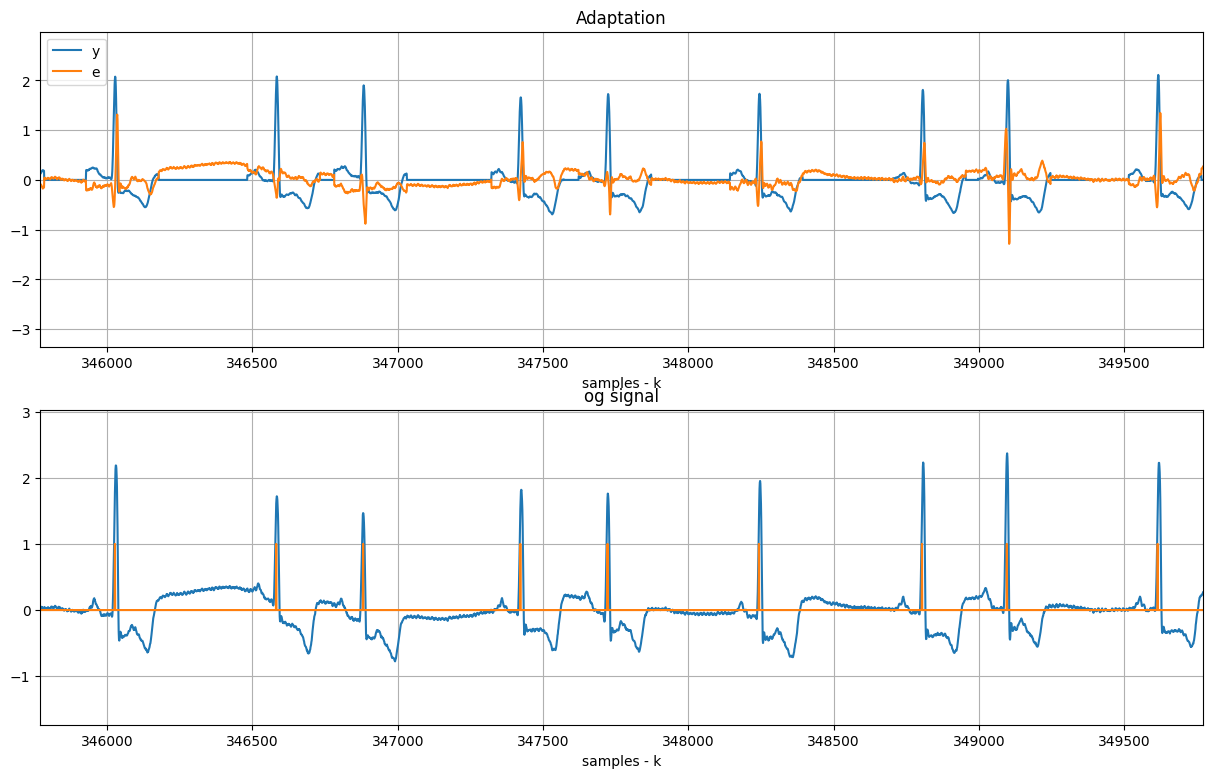

In [119]:
record_name = '219'
record2 = wfdb.rdrecord(record_name, pn_dir='mitdb')
# Extract ECG data from two leads as numpy arrays
lead1_data = record2.p_signal[:, 0]  # First lead
lead2_data = record2.p_signal[:, 1]  # Second lead

filtered_sig1 = filter_wandering_noise(lead1_data)

filtered_sig2 = filter_60hz(filtered_sig1, 360)

arf_error, filtered_sig3 = arf_filter(filtered_sig2, 250, mu=0.5)

loc = 347770
buff = 2000

plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(filtered_sig3, label='y')
plt.plot((arf_error), label='e')
plt.legend()
plt.grid()
plt.xlim(loc-buff,loc+buff)
plt.subplot(212);plt.title("og signal");plt.xlabel("samples - k")
plt.plot((filtered_sig2), label='signal')
plt.plot((detect_r_peak(filtered_sig2)), label='r spikes')
plt.grid()
plt.xlim(loc-buff,loc+buff)
plt.show()

# Procesamos una señal de interés con latido ectópico

In [296]:
record_name = '105'


record2 = wfdb.rdrecord(record_name, pn_dir='mitdb')

# Extract ECG data from two leads as numpy arrays
lead1_data = record2.p_signal[:, 0]  # First lead
lead2_data = record2.p_signal[:, 1]  # Second lead


data = lead1_data[50000:60000]


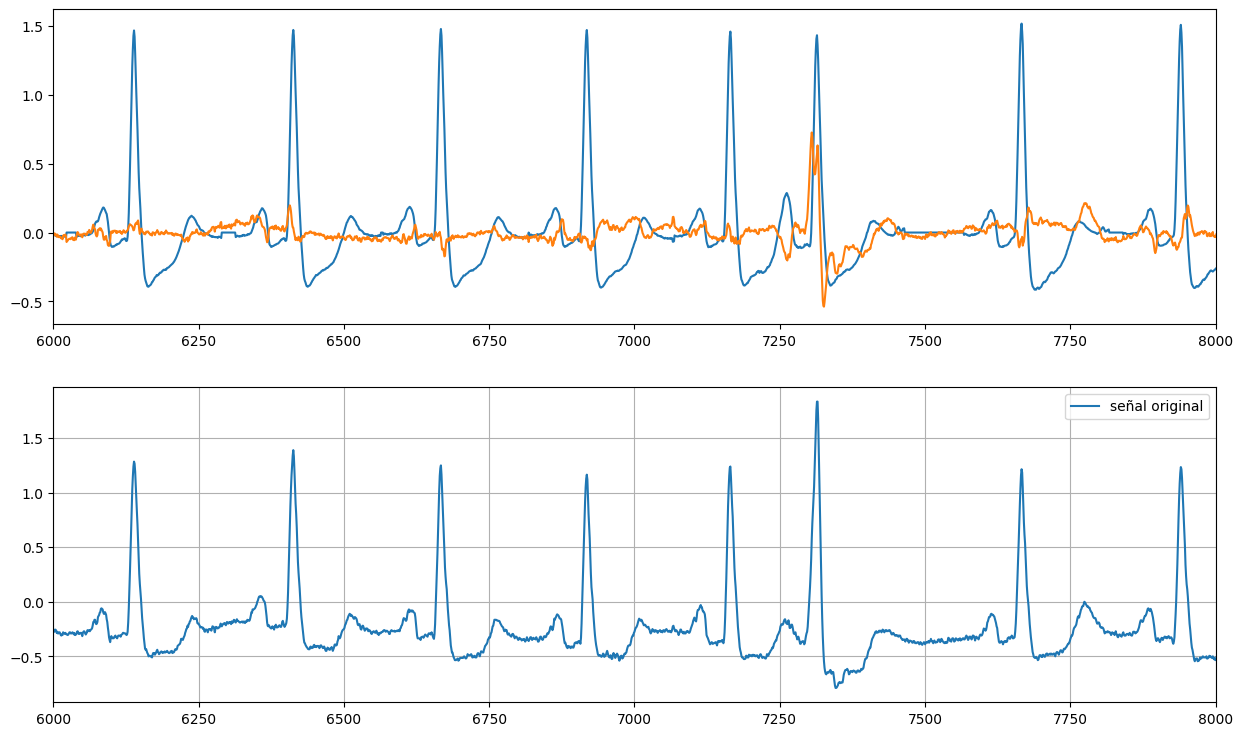

In [312]:
filtered_sig1 = filter_wandering_noise(data)

filtered_sig2 = filter_60hz(filtered_sig1, 360)

arf_error, filtered_sig3 = arf_filter(filtered_sig2, 250, mu=0.2)
plt.figure(figsize=(15,9))
plt.subplot(211)

plt.plot(filtered_sig3, label='señal filtrada')
plt.plot(arf_error, label='error')
plt.xlim(6000,8000)
plt.subplot(212)
plt.plot(data, label= 'señal original')
plt.xlim(6000,8000)
plt.legend()
plt.grid()